In [408]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
from io import StringIO
import scipy.special as scp
from scipy.optimize import curve_fit, leastsq 
from sklearn.linear_model import LinearRegression
import os
import datetime as dt
from datetime import datetime
import statistics
#%matplotlib inline

sns.set_style("whitegrid", {'grid.linestyle': '--'})
pd.set_option('display.float_format', lambda x: '%.8f' % x)

In [277]:
df = pd.read_excel(r"C:\Users\jfrank\OneDrive - Specialized Bicycle Components\Projects\MetFit2.0\20200701 Jesse Frank (Mixing Chamber 10w updown).xlsx")
df.head()

# Start Pre-Procession Data Files
df = df.iloc[:, 9:] #Get rid of the first 9 columns

for col in df.columns: #Combine units with Column name via UNderscore
    df.rename(columns = {col:col+'_'+df.loc[0, col]}, inplace=True)
df.head()    

#Delete first 2 rows with units and NAN
df = df.drop([0,1])
df = df.reset_index(drop=True)
df.head()


#Convert time data series to seconds and add new column
df['seconds']= df['t_s'].apply(lambda x:(x.hour * 60 + x.minute) * 60 + x.second)

df.head()
#df.info()

t_s    Rf_1/min VT_L(btps)    VE_L/min IV_mL    VO2_mL/min  \
0  00:01:00          33 1.30600000 43.10000000  1065 2312.73559880   
1  00:01:10 33.70000000 1.44200000 48.60000000  1553 2571.88775350   
2  00:01:20 32.40000000 1.46900000 47.60000000  1227 2471.14363800   
3  00:01:30 31.70000000 1.56500000 49.60000000  1562 2542.83424420   
4  00:01:40 31.70000000 1.47000000 46.60000000  1116 2364.71972270   

    VCO2_mL/min     RQ_---  VE/VO2_--- VE/VCO2_---  ... CO2 Delay_ms  \
0 1660.32554500 0.72000000 17.60000000 24.60000000  ...          680   
1 1912.32671340 0.74000000          18 24.20000000  ...          680   
2 1884.78364280 0.76000000 18.30000000 24.10000000  ...          680   
3 1968.08285730 0.77000000 18.60000000 24.10000000  ...          680   
4 1849.05531730 0.78000000 18.80000000          24  ...          680   

  GPS Heading_DEG Bike Wheel Cadence_rpm Bike Power_Watt RH Sample_%  \
0               0                    195    149.80000000          72   
1               0                    191             150          71   
2               0                    187    149.60000000          71   
3               0                    194    149.60000000          71   
4               0                    192             150          70   

  Satellites_--- Fixing_--- Satellites SNR_dB HRR_bpm seconds  
0              7      False                25      97      60  
1              8      False                25      91      70  
2              8      False                25      93      80  
3              8      False                25      90      90  
4              7      False                25      93     100  

[5 rows x 66 columns]

In [332]:
#data we care about
df_care = df.iloc[2:-2]
#df_care = df_care.astype('int')
df_care.head()
df_care["seconds"] = df_care["seconds"] - df_care["seconds"].iloc[0]
#df_care.info()
#for index in df_care["seconds"]:
    #df_care['seconds'] = df_care['seconds'].iloc[index]-df_care['seconds'].iloc[2]
#df_care.iloc[0]#["Bike Power_Watt"]
#df_care['seconds']
df_care.head()
df_care.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 239 entries, 2 to 240
Data columns (total 66 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   t_s                     239 non-null    object
 1   Rf_1/min                239 non-null    object
 2   VT_L(btps)              239 non-null    object
 3   VE_L/min                239 non-null    object
 4   IV_mL                   239 non-null    object
 5   VO2_mL/min              239 non-null    object
 6   VCO2_mL/min             239 non-null    object
 7   RQ_---                  239 non-null    object
 8   VE/VO2_---              239 non-null    object
 9   VE/VCO2_---             239 non-null    object
 10  VO2/Kg_mL/min/Kg        239 non-null    object
 11  METS_---                239 non-null    object
 12  HR_bpm                  239 non-null    object
 13  VO2/HR_mL/beat          239 non-null    object
 14  FeO2_%                  239 non-null    object
 15  FeCO2_

C:\Users\jfrank\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [514]:
#Isolate only the variables that we want and chage Dtype from Object to float.
df_care_test = df_care[['VO2_mL/min',  'RQ_---','HR_bpm','EEm_kcal/min','Bike Power_Watt']]
df_care_test = df_care_test.astype(float)
df_care_test.info()




SyntaxError: unexpected EOF while parsing (<ipython-input-514-d6d75927cdc1>, line 6)

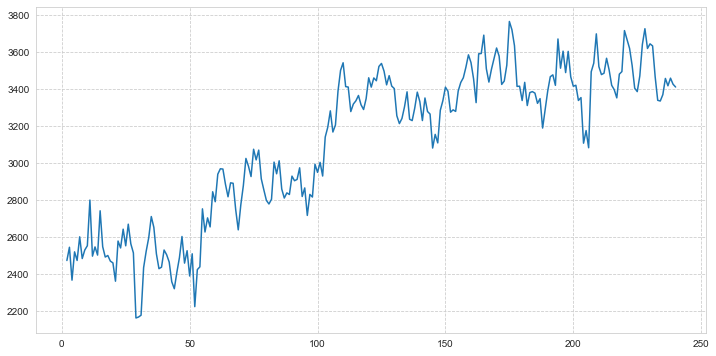

In [517]:
plt.figure (figsize = (12, 6))
plt.plot(df_care_test["VO2_mL/min"])

In [510]:
df_care_test['seconds_group'] = df_care['seconds'] // 240
df_grouped = pd.DataFrame(df_care_test.groupby('seconds_group').mean())

df_grouped['Pmet_Watt'] = df_grouped['EEm_kcal/min']*69.78
df_grouped['GME_%'] = df_grouped['Bike Power_Watt']/df_grouped['EEm_kcal/min']
df_grouped.iloc[9]= ((df_grouped.iloc[9] + df_grouped.iloc[10])/2)
df_grouped = df_grouped.iloc[:-1]
df_grouped
data = []
for index,val in enumerate(df_grouped["VO2_mL/min"]):
    data.append(dict(df_care_test.loc[df_care_test['seconds_group'] == index].iloc[-3:].mean()))
    
df_steady = pd.DataFrame(data)
df_steady
df_steady['Pmet_Watt'] = df_steady['EEm_kcal/min']*69.78
df_steady['GME_%'] = df_steady['Bike Power_Watt']/df_steady['EEm_kcal/min']
df_steady

VO2_mL/min     RQ_---       HR_bpm  EEm_kcal/min  Bike Power_Watt  \
0 2576.83565560 0.83333333 106.33333333   12.41000000     150.20000000   
1 2527.42418373 0.85000000 104.33333333   12.21666667     150.06666667   
2 2960.93660193 0.86000000 116.33333333   14.34000000     190.13333333   
3 2802.75116370 0.85333333 118.00000000   13.56333333     190.00000000   
4 3406.00997510 0.90333333 132.00000000   16.66666667     230.06666667   
5 3207.32341800 0.87000000 131.66666667   15.58666667     220.00000000   
6 3484.37238227 0.90000000 138.66666667   17.02666667     230.00000000   
7 3443.98774127 0.87000000 135.66666667   16.72666667     220.60000000   
8 3439.77176127 0.88000000 138.00000000   16.74666667     229.93333333   
9 3433.70239217 0.87666667 136.00000000   16.70666667     220.00000000   

   seconds_group     Pmet_Watt       GME_%  
0     0.00000000  865.96980000 12.10314263  
1     1.00000000  852.47900000 12.28376535  
2     2.00000000 1000.64520000 13.25894933  
3     3.00000000  946.44940000 14.00835586  
4     4.00000000 1163.00000000 13.80400000  
5     5.00000000 1087.63760000 14.11462789  
6     6.00000000 1188.12080000 13.50822240  
7     7.00000000 1167.18680000 13.18852132  
8     8.00000000 1168.58240000 13.73009554  
9     9.00000000 1165.79120000 13.16839585

In [476]:








#df_grouped.iloc[9] = 
#print(df_grouped)
#df_care_test.iloc[2]

#df_care
#df_g = pd.DataFrame(df_care_test.groupby('seconds_group')['VO2_mL/min'].mean())
#df_g = pd.DataFrame()#columns = aa.groups
#aa.groups

VO2_mL/min        2802.75116370
RQ_---               0.85333333
HR_bpm             118.00000000
EEm_kcal/min        13.56333333
Bike Power_Watt    190.00000000
seconds_group        3.00000000
dtype: float64

In [511]:
#Separate the up (230W) and down (220W) trials.

df_up =pd.DataFrame([df_steady.iloc[4], df_steady.iloc[6], df_steady.iloc[8]])
std_up = df_up.std()
df_down =pd.DataFrame([df_steady.iloc[5], df_steady.iloc[7], df_steady.iloc[9]])
std_down = df_down.std()
std_down


VO2_mL/min        133.76797715
RQ_---              0.00384900
HR_bpm              2.41139271
EEm_kcal/min        0.65248244
Bike Power_Watt     0.34641016
seconds_group       2.00000000
Pmet_Watt          45.53022460
GME_%               0.54059126
dtype: float64

In [512]:
plt.figure (figsize = (12, 6))
plt.title('Repeatability of Up and Down Trials')
plt.xlabel('Repeat Number')
plt.ylabel('Metabolic Power (W)')
plt.ylim(1000, 1400)
plt.errorbar([1, 2, 3],df_up['Pmet_Watt'],yerr=std_up['Pmet_Watt'],fmt = 'o-')
plt.grid(axis = "x", which = "both")
plt.errorbar([1, 2, 3],df_down['Pmet_Watt'],yerr=std_down['Pmet_Watt'],fmt = 'ro-')
plt.legend(['230 W', '220 W'])
plt.show()

2.8967768257854094


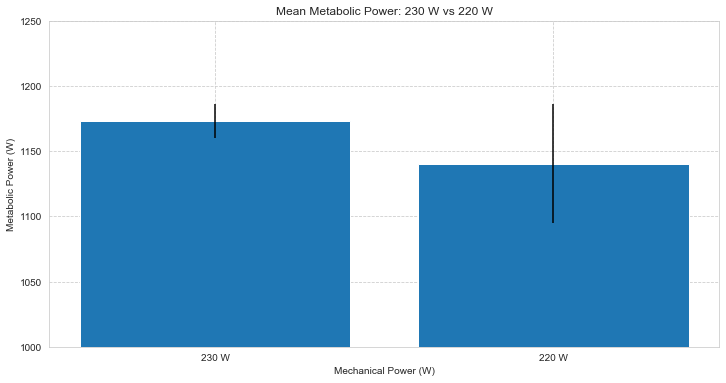

In [513]:
# Average Data for Up and Down trials
up_mean = df_up.mean()
up_std = df_up.std()

down_mean = df_down.mean()
down_std = df_down.std()

plt.figure (figsize = (12, 6))

twos = [up_mean['Pmet_Watt'],down_mean['Pmet_Watt']]
twos_std = [up_std['Pmet_Watt'],down_std['Pmet_Watt']]
cond = ['230 W', '220 W']
plt.bar(cond,twos, yerr=twos_std)
plt.title('Mean Metabolic Power: 230 W vs 220 W')
plt.ylabel('Metabolic Power (W)')
plt.xlabel('Mechanical Power (W)')
plt.ylim(1000,1250)
plt.grid(b = 'k',which = 'both')

pdiff = ((up_mean['Pmet_Watt']-down_mean['Pmet_Watt'])/down_mean['Pmet_Watt'])*100
print(pdiff)

In [ ]:
plt.plot()

In [306]:
"""
#aa = df_care.groupby(df_care['seconds'] // 240)
#df_g = pd.DataFrame(columns = aa.groups)
for index,name in aa:
    aaa = aa.get_group(index).mean()
    data = aaa.to_frame()
    df_g[index].append(data)
    #print(index)
    #df_g.append(aaa.to_frame())

    
#df_g = df_g.T
df_g
#aa.groups
#df_g
#df_g.append(aaa.to_frame())


Empty DataFrame
Columns: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Index: []

In [118]:
#stages = df_care.groupby("VO2_mL/min")[df_care["seconds"] // 240].mean()
#stages = df_care.groupby["Bike Power_Watt"](df_care.seconds //240).mean()
#stages["VO2_mL/min"].groups

KeyError: 'Columns not found: 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10'